In [1]:
"""
Ejemplo: Riesgo de tasa de interés en el modelo de Merton
---------------------------------------------------------
Objetivo general:
- Usar datos reales (AAPL, MSFT, GOOGL y ^IRX) para:
  1) Estimar parámetros (retornos y riesgos) de las acciones.
  2) Construir el portafolio óptimo de Merton.
  3) Medir la sensibilidad de ese portafolio a cambios en la tasa libre de riesgo.
"""

import numpy as np              # Operaciones numéricas (arrays, álgebra lineal)
import pandas as pd             # Manejo de series y tablas de datos

from Methodologies_Port import Do_portfolio  # Clase con métodos de portafolios y Merton
from yahoo_data import yahoo_data            # Clase para descargar y procesar datos de Yahoo Finance

# Para graficar al final
import matplotlib.pyplot as plt  # Librería de gráficos básicos

# %%
# ----------------------------
# 1. Definir universo y fechas
# ----------------------------

tickers = ["AAPL", "MSFT", "GOOGL"]   # Lista de símbolos de las 3 acciones riesgosas
rf_ticker = "^IRX"                    # Símbolo de la tasa libre de riesgo (T-Bill 13 semanas)

start = "2020-01-01"                  # Fecha de inicio del periodo de estudio
end   = "2024-12-31"                  # Fecha de fin del periodo de estudio

In [2]:
# %%
# ------------------------------------------
# 2. Descargar y alinear datos (acciones + rf)
# ------------------------------------------

# Llamamos a un método de clase que:
# - Descarga precios ajustados de las acciones y de ^IRX.
# - Alinea calendarios (mismas fechas para todos).
# - Elimina filas con valores faltantes.
data_all = yahoo_data.preprocess_data(
    tickers=tickers,          # Lista de acciones riesgosas
    rf_ticker=rf_ticker,      # Ticker de la tasa libre de riesgo
    start=start,              # Fecha inicial
    end=end,                  # Fecha final
    price_col="Adj Close",    # Usar columna de precios ajustados
    auto_adjust=False         # No ajustar automáticamente (ya usamos Adj Close)
)

# Mostrar las columnas descargadas (acciones + ^IRX)
print("Columnas en data_all:", data_all.columns)
# Vista rápida de las primeras filas para verificar que los datos se ven razonables
data_all.head()

Columnas en data_all: Index(['AAPL', 'GOOGL', 'MSFT', '^IRX'], dtype='object', name='Ticker')


Ticker,AAPL,GOOGL,MSFT,^IRX
Date,,,,
2020-01-02,72.468269,67.965233,152.791122,1.495
2020-01-03,71.763733,67.609695,150.888641,1.473
2020-01-06,72.335579,69.411758,151.278641,1.488
2020-01-07,71.995354,69.277687,149.899323,1.500
2020-01-08,73.153488,69.770790,152.286972,1.493


In [3]:
# %%
# -------------------------------------
# 3. Separar activos y tasa libre de rf
#    y convertir la tasa a unidades útiles
# -------------------------------------

# Extraemos solo las columnas de las acciones (precios de AAPL, MSFT, GOOGL)
prices_assets = data_all[tickers]

# Extraemos la columna de la tasa libre de riesgo como DataFrame de 1 columna
rf_raw = data_all[[rf_ticker]]   # Sigue en % anual (como se reporta en Yahoo)

# Convertir tasa: de "% anual" a:
# - rf_ann: tasa anual en proporción (ej: 5% -> 0.05)
# - rf_daily_log: tasa diaria equivalente en log-retornos
rf_ann, rf_daily_log = yahoo_data.convert_rf(
    data_rf=rf_raw,       # DataFrame con la serie de ^IRX
    days_per_year=252,    # Número de días hábiles que usamos para anualizar
    kind="log"            # Pedimos tasa diaria en formato log (para futuros usos)
)

# Imprimir las primeras filas de la tasa anual en proporción
print("rf_ann (primeros días):")
print(rf_ann.head())

# Imprimir las primeras filas de la tasa diaria en log-retornos
print("\nrf_daily_log (primeros días):")
print(rf_daily_log.head())


rf_ann (primeros días):
            ^IRX_ann
Date                
2020-01-02   0.01495
2020-01-03   0.01473
2020-01-06   0.01488
2020-01-07   0.01500
2020-01-08   0.01493

rf_daily_log (primeros días):
            ^IRX_daily_log
Date                      
2020-01-02        0.000059
2020-01-03        0.000058
2020-01-06        0.000059
2020-01-07        0.000059
2020-01-08        0.000059


In [4]:
# %%
# ---------------------------------------------------
# 4. Estimar μ (retorno esperado) y Σ (covarianza) anuales
#    con la clase Do_portfolio
# ---------------------------------------------------

# Creamos una instancia de Do_portfolio con los mismos tickers y periodo
dp = Do_portfolio(
    tickers=tickers,  # Lista de acciones
    start=start,      # Fecha inicial
    end=end           # Fecha final
)

# Calcula retornos diarios, estima la media histórica y la anualiza
dp.mean_estimation(tipo="hist", periods_per_year=252)  # Guarda resultado en dp.bar_mu

# Calcula la matriz de covarianza diaria y la anualiza
dp.var_estimation(tipo="hist", periods_per_year=252)   # Guarda resultado en dp.bar_var

# Guardamos μ anual y Σ anual en variables auxiliares
mu_ann = dp.bar_mu       # Serie: retorno esperado anual por acción
Sigma_ann = dp.bar_var   # DataFrame: matriz de covarianza anual

# Mostramos los retornos esperados anuales
print("μ_ann (retornos esperados anuales):")
print(mu_ann)

# Mostramos la matriz de covarianza anual
print("\nΣ_ann (covarianza anual):")
print(Sigma_ann)


μ_ann (retornos esperados anuales):
Ticker
AAPL     0.299545
GOOGL    0.259848
MSFT     0.250702
dtype: float64

Σ_ann (covarianza anual):
Ticker      AAPL     GOOGL      MSFT
Ticker                              
AAPL    0.100420  0.066844  0.072340
GOOGL   0.066844  0.105677  0.073995
MSFT    0.072340  0.073995  0.093066


In [5]:
# %%
# --------------------------------------------
# 5. Fijar preferencias del inversor y tasa base
# --------------------------------------------

gamma = 3.0  # Aversión al riesgo (CRRA) del inversor; 3 ~ nivel intermedio

# Tomamos el último valor disponible de la tasa anual rf_ann como tasa base r0
# - rf_ann es un DataFrame de 1 columna, por eso usamos iloc[-1, 0]
r0 = float(rf_ann.iloc[-1, 0])

# Mostramos parámetros clave
print(f"gamma = {gamma}")
print(f"r0 (tasa libre anual usada en Merton) = {r0:.4f}")


gamma = 3.0
r0 (tasa libre anual usada en Merton) = 0.0418


In [6]:
# %%
# ------------------------------------------------------
# 6. Calcular portafolio de Merton y sensibilidad a la tasa
# ------------------------------------------------------

# Llamamos al método que:
# - Usa μ_ann y Σ_ann (cuando use_bar=True).
# - Aplica la regla de Merton.
# - Devuelve portafolio óptimo y sensibilidad dπ/dr.
res_merton_ir = dp.interest_rate_risk_merton(
    gamma=gamma,        # Aversión al riesgo
    r0=r0,              # Tasa libre de riesgo anual base
    dr=1e-4,            # Paso pequeño para derivada numérica de verificación
    use_bar=True,       # Indica que use dp.bar_mu y dp.bar_var ya estimados
    kind="simple",      # (si use_bar=False, controlaría el tipo de retorno diario)
    periods_per_year=252
)

# Extraemos el portafolio óptimo de Merton a la tasa r0
pi_merton = res_merton_ir["pi"]

# Extraemos la derivada analítica de los pesos con respecto a la tasa
dpi_dr_analytic = res_merton_ir["dpi_dr_analytic"]

# Extraemos la derivada numérica (cociente incremental) para chequeo
dpi_dr_numeric = res_merton_ir["dpi_dr_numeric"]

# Imprimimos el portafolio óptimo
print("Pesos Merton π(r0):")
print(pi_merton)

# Imprimimos la sensibilidad analítica
print("\nDerivada analítica dπ/dr:")
print(dpi_dr_analytic)

# Imprimimos la sensibilidad numérica de chequeo
print("\nDerivada numérica dπ/dr (chequeo):")
print(dpi_dr_numeric)


Pesos Merton π(r0):
AAPL     0.669435
GOOGL    0.236364
MSFT     0.039872
Name: pi_Merton, dtype: float64

Derivada analítica dπ/dr:
AAPL    -1.432315
GOOGL   -1.172953
MSFT    -1.535758
Name: dpi_dr_analytic, dtype: float64

Derivada numérica dπ/dr (chequeo):
AAPL    -1.432315
GOOGL   -1.172953
MSFT    -1.535758
Name: dpi_dr_numeric, dtype: float64


In [7]:
# %%
# -------------------------------------------------
# 7. Aplicar un shock de tasa y aproximar nuevos pesos
# -------------------------------------------------

delta_r = 0.01   # Shock de tasa: +100 puntos básicos (1% en términos absolutos)

# Cambio aproximado en los pesos de Merton ante el shock:
# Δπ ≈ (dπ/dr) * Δr   (cálculo componente a componente)
delta_pi = dpi_dr_analytic * delta_r

# Nuevos pesos aproximados del portafolio a la tasa r0 + 1%
pi_new = pi_merton + delta_pi

# Mostrar el cambio en los pesos ante el shock
print("Cambio en pesos ante +100 bps (Δπ):")
print(delta_pi)

# Mostrar los nuevos pesos aproximados luego del shock de tasa
print("\nNuevos pesos aproximados π(r0 + 1%):")
print(pi_new)


Cambio en pesos ante +100 bps (Δπ):
AAPL    -0.014323
GOOGL   -0.011730
MSFT    -0.015358
Name: dpi_dr_analytic, dtype: float64

Nuevos pesos aproximados π(r0 + 1%):
AAPL     0.655112
GOOGL    0.224635
MSFT     0.024515
dtype: float64


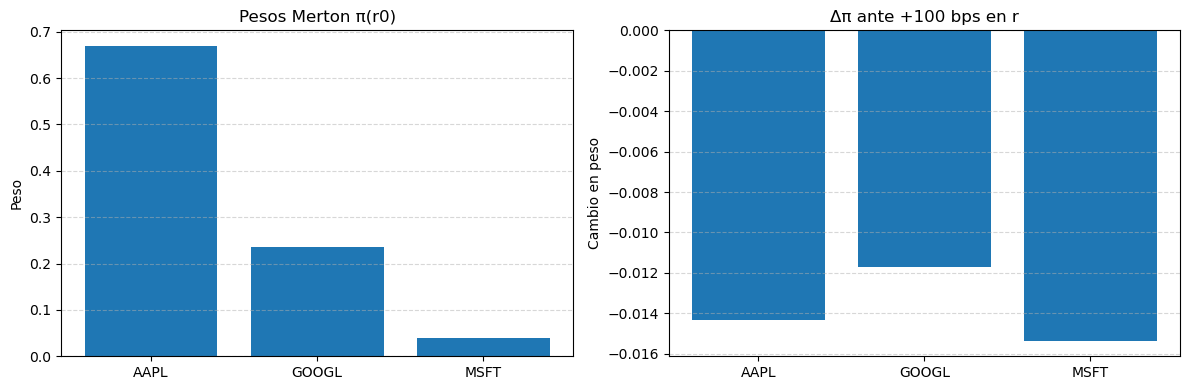

In [8]:
# %%
# -----------------------------
# 8. Visualizar resultados (plots)
# -----------------------------

# Creamos una figura con 2 subgráficos en una fila
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Panel izquierdo: pesos Merton base ---
axes[0].bar(pi_merton.index, pi_merton.values)     # Barras con los pesos iniciales
axes[0].set_title("Pesos Merton π(r0)")            # Título del gráfico
axes[0].set_ylabel("Peso")                         # Etiqueta del eje Y
axes[0].grid(axis="y", ls="--", alpha=0.5)         # Líneas guía horizontales

# --- Panel derecho: cambio en pesos ante +100 bps ---
axes[1].bar(delta_pi.index, delta_pi.values)       # Barras con el cambio Δπ
axes[1].set_title("Δπ ante +100 bps en r")         # Título del gráfico
axes[1].set_ylabel("Cambio en peso")               # Etiqueta del eje Y
axes[1].grid(axis="y", ls="--", alpha=0.5)         # Líneas guía horizontales

# Ajustar espaciado para que los gráficos no se encimen
plt.tight_layout()

# Mostrar la figura en pantalla
plt.show()


**Resumen**  

- A partir de los precios históricos de AAPL, MSFT y GOOGL calculamos retornos diarios, su media y su varianza, y los pasamos a escala **anual**: eso nos da µ (retornos esperados) y Σ (riesgo y correlaciones).  
- Con la serie del T-Bill (^IRX) convertida a **tasa libre anual** tomamos el último dato (≈ 4.2%): esa es la tasa \(r_0\) que entra al modelo.  
- Fijamos una aversión al riesgo **γ = 3**, que representa a un inversor moderado: cuanto mayor es γ, más peso termina en el activo libre.  
- Con µ, Σ, γ y \(r_0\), el modelo de Merton entrega los **pesos óptimos** en acciones: alrededor de 67% en AAPL, 24% en GOOGL y 4% en MSFT, dejando cerca del 5% en la tasa libre de riesgo.  
- Luego calculamos la **sensibilidad de esos pesos a la tasa libre**: todas las derivadas salen negativas, lo que significa que si sube la tasa, el portafolio óptimo reduce su posición en las tres acciones.  
- Al simular un aumento de **+1% en la tasa libre**, los pesos de AAPL, GOOGL y MSFT caen aproximadamente 1.4, 1.2 y 1.5 puntos porcentuales, respectivamente; la parte en renta variable baja de ~95% a ~90%, y ese ~5% se mueve hacia el activo libre.  
- Conclusión: en el modelo de Merton, un alza de tasas hace que un inversor racional **rebalancee** reduciendo acciones y aumentando su posición en el activo libre de riesgo; esa reacción cuantificada es nuestro *interest rate risk* del portafolio.
